# Введение в статистику.

In [3]:
from scipy.stats import (
    binom
)
import numpy as numpy
from seaborn import distplot
from matplotlib import pyplot
import seaborn
import random

import sys
sys.path.append('.')

In [4]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [5]:
inverse_plot_colorscheme()

______

В этой лекции мы начинаем знакомство с математической статистикой. На примере бизнес-задачи мы разберём, зачем нужна статистика, как применить её к конкретной задаче и какие ошибки можно совершить, если не пользоваться математическим аппаратом.

## Часть 1. Зачем нужна прикладная статистика

Предположим, вы придумали идею для стартапа. Вы договорились с магазинами одежды об осуществлении доставки и наняли курьеров, которые собирают из магазинов заказы и доставляют клиентам. Предположим, доставка в вашем сервисе стоит 1000 рублей, а курьеру за работу требуется заплатить 500 рублей. Казалось бы, прибыль очевидна, но внезапно вы понимаете, что от одежды часто отказываются, если она не подходит. Это понимают и ваши инвесторы, которых вы просите помочь с рекламой и инфраструктурой. Они согласны помогать вам, если шанс отказа будет меньше 50%.

**Как вам убедить инвесторов?**

Вы решаетесь на эксперимент. Самостоятельно находите $30$ клиентов и доставляете им заказы через курьеров. Оплачивают покупку $19$ из них, остальные отказываются. $19$ &mdash; это больше половины покупателей, но достаточно ли этого, чтобы доказать успешность вашего бизнеса?

### Модель и наблюдения

Решая такую задачу, мы предполагаем, что есть аудитория, которая воспользуется нашим сервисом. Она называется *генеральной совокупностью*. Если мы запустим сервис на всех пользователей, то в нём будет доля успешных доставок, обозначим её $\mu$. Это некоторый параметр, который мы не знаем. Всё, что мы можем делать &mdash; это проводить эксперименты и *наблюдать*. Мы не можем протестировать продукт на всех, но можем собрать *выборку* из генеральной совокупности и пронаблюдать долю успехов. По проведённому эксперименту видим, что наблюдаемая вероятность оплаты $\frac{19}{30} = 63\%$.

Но до сих пор неясно, является ли это доказательством, что истинное $\mu > 50\%$.

Посмотрим, почему это может не быть доказательством. Положим вероятность $\mu = 0.5$ и математически смоделируем, какие могли быть статусы наших 30 заказов.

**Алгоритм моделирования**

- Так как вероятность успеха 0.5, можно подбросить монетку для моделирования того, был ли успех
- Чтобы подбросить монетку, воспользуемся функцией `random.randint`, которая возвращает случайное целое число из диапазона, в нашем случае от 0 до 1, где 1 означает успешную доставку
- Подкинем монетку 30 раз, чтобы получить результаты 30 доставок

In [6]:
# фиксируем последовательность рандома для воспроизводимости
random.seed(20000)

In [7]:
statuses = []
for _ in range(30):  # моделируем 30 доставок
    status = random.randint(0, 1)  # генерируем случайное число, 0 или 1
    statuses.append(status)
exp_chance = sum(statuses) / 30  # доля успехов

In [8]:
print('Доля успехов: {:.0%}'.format(exp_chance))

Доля успехов: 67%


Видим, что в эксперименте доля успешных заказов была даже выше $63\%$, но модельная вероятность была $50\%$.

Поэтому, к сожалению, **точно сказать, какой является $\mu$ в генеральной совокупности, и больше ли она 50%, нельзя**, сколько бы мы ни наблюдали за доставками. Но с помощью прикладной статистики мы введём аппарат, который позволяет принять правильное продуктовое решение, в том числе и для этой задачи. 

## Часть 2. Статистические гипотезы

Мы увидели, что можно получить довольно много успехов даже в случае вероятности $\mu = 0.5$. Но на самом деле для этого пришлось подбирать seed. Если перезапустить только ячейку с экспериментом, доля успехов получится уже меньше половины! Так может быть большая доля успехов случается очень редко, и мы готовы принять большое в качестве доказательства?

Чтобы это понять, надо ответить на вопрос:

❓ **Насколько часто может быть такое, что при $\mu = 0.5$ получается большая доля успехов**?

Для этого обратимся к теории вероятностей. Успешность каждого заказа &mdash; это случайная величина $\xi$ из распределения Бернулли. Параметр этого распределения, вероятность успеха, мы не знаем.

$$ \xi = \xi_1, \xi_2, \dots, \xi_{30} \sim Bern(\mu) - \text{выборка} $$

$$ \mu - \text{неизвестный параметр} $$

### Гипотеза

При этом у нас есть продуктовая гипотеза о том, как устроено распределение в генеральной совокупности. Нас интересует доказательство того, что $\mu > 0.5$. В механизме проверки гипотез в статистике рассматривают две гипотезы. Нулевая гипотеза говорит о том, что мы хотим опровергнуть. Альтернативная гипотеза говорит о том, что мы хотим доказать.

$$ \mathsf{H}_0: \mu = 0.5 $$
$$ \mathsf{H}_1: \mu > 0.5 $$


Заметим, что если в эксперименте $30$ доставок, то можно смотреть не на долю успехов, а просто на количество. Переформулируем вопрос:

❓ **Насколько часто может быть такое, что при справедливости $\mathsf{H}_0$ получается большое количество успехов**?

Количество успехов &mdash; это сумма независимых бернуллиевских величин, значит имеет биномиальное распределение. Посмотрим, как оно выглядит.

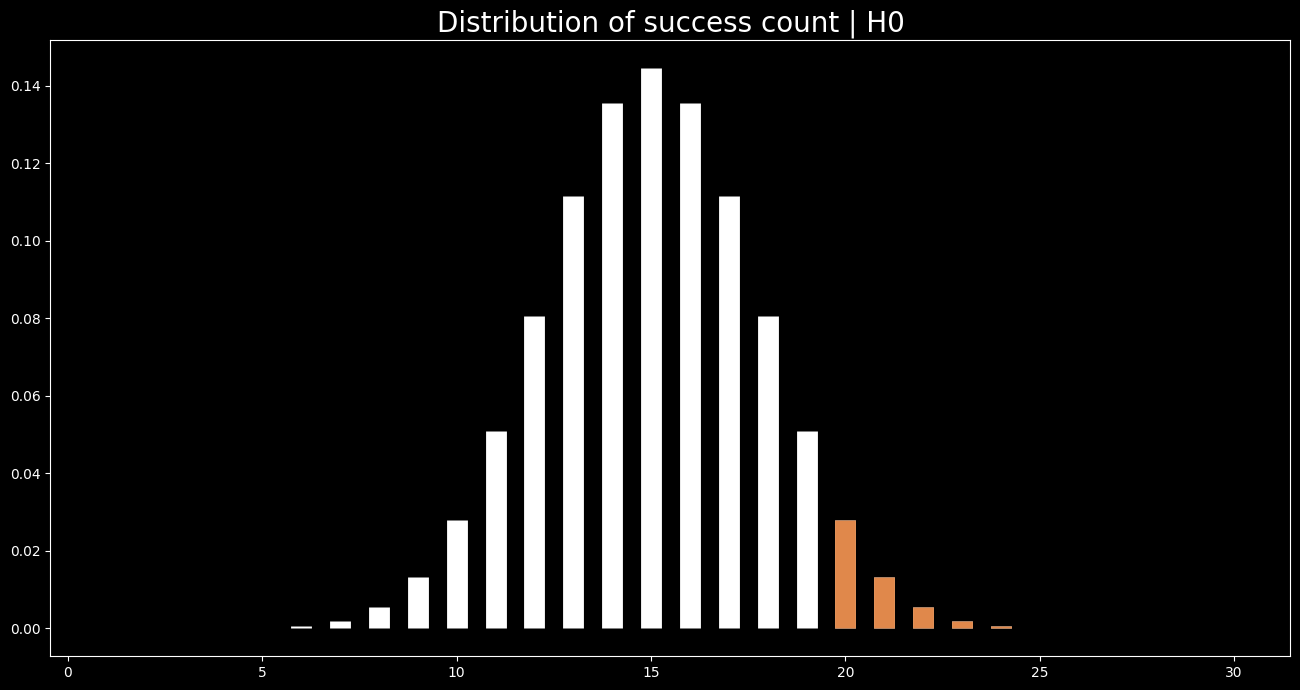

Видим, например, что $20$ и более успехов случаются достаточно редко. Для принятия решения можно пользоваться правилом `инвестируем, если успехов хотя бы 20`. Если $\mathsf{H}_0$ и верна, то ошибаться, используя это правило, мы будем редко.

### Критерий

Только что мы придумали алгоритм, который по выборке $\xi$ либо признаёт, что мы нашли доказательство в пользу $\mathsf{H}_1$, либо говорит, что его не нашли. Соответственно будет либо **отвергать $\mathsf{H}_0$**, либо **не отвергать**.

Такой алгоритм называется **критерием**. Представим его как функцию $S$, которая принимает реализацию выборки и возвращает $1$, если нужно отвергнуть $\mathsf{H}_0$, и $0$ иначе.

$$
S(\xi) = \begin{cases}
    1, \text{ если отвергаем } \mathsf{H}_0 \\
    0, \text{ иначе}
\end{cases}
$$

Запишем правило, которое сформулировали выше для нашей задачи:

$$
S(\xi) = \begin{cases}
    1, \text{ если } \sum \xi_i \geqslant 20 \\
    0, \text{ иначе}
\end{cases}
$$

Обычно сокращают запись и пишут просто правило, по которому отвергаем $\mathsf{H}_0$

$$ S = \{\sum \xi_i \geqslant 20\} $$

Обозначим $Q = \sum \xi_i$, $С = 20$, тогда критерий принимает вид

$$ S = \{Q(\xi) \geqslant C\} $$

Так устроено большинство классических критериев в прикладной статистике, поэтому величинам в нём даны специальные названия. $Q$ называется **статистикой критерия**, $C$ &mdash; **критическим значением**.

$Q$ может быть любой функцией от выборки, которую вы считаете логичной для проверки гипотезы. В нашем случае это количество успехов, или сумма всех $\xi_i$. Но вы можете выбрать и другие: максимальное значение, сумму первых 5 значений или даже просто первый элемент.

### Поиск критического значения

Снова перепишем наш основной вопрос, только теперь с использованием нашего критерия $S$:

❓ **Насколько часто может быть такое, что при справедливости $\mathsf{H}_0$ критерий $S$ отвергает гипотезу**?

Ответ на этот вопрос зависит от критического значения. Сейчас мы взяли его равным $20$, увидев на картинке, что большие отклонения происходят при $\mathsf{H}_0$ редко. Но что значит редко и насколько редко, не сказали. Теперь наша цель понять, как выбрать критическое значение $C$, исходя из частоты ошибок нашего критерия.

Выбирая $C$, мы можем либо часто отвергать нулевую гипотезу, когда $C$ мало, либо можем делать это реже, когда $C$ большое. Чтобы выбрать правильное значение, нужно определиться, когда наш критерий ошибается.

**C = 16**

Если отвергать гипотезу при получении хотя бы 16 успешных доставок из 30, то это вряд ли устроит инвесторов. Да, успехов больше половины. Но если в генеральной совокупности вероятность 0.5, то почти в половине случаев мы будем отвергать гипотезу. Критерий ошибочно возвращает $1$, то есть это ошибка **False Positive**.

**C = 29**

В таком случае будем отвергать гипотезу только при 29 или 30 успехах. Эти значения, конечно, говорят о том, что отклонение от 50% успехов сильное. Но если в генеральной совокупности вероятность, к примеру, 60%, то такие значения будут получаться редко. А ведь такие вероятности тоже устроили бы инвесторов, и мы бы смогли открыть стартап! А с таким критерием мы вряд ли добьёмся этого. Не отвергнуть гипотезу $\mathsf{H}_0$, когда она неверна - это тоже ошибка. Она называется **False Negative**, так как критерий вернул 0 ошибочно.

$$ \text{False Positive (FP) } - \mathsf{H}_0\ отвергается,\ когда\ она\ верна $$
$$ \text{False Negative (FN) } - \mathsf{H}_0\ не\ отвергается,\ когда\ она\ не верна $$

В нашей задаче инвесторам важнее False Positive. Им очень не хочется попасть в ситуацию, когда им показали доказательство успешности бизнеса, а оказалось, что от большинства заказов отказываются, и компания не получает прибыль. Это приведёт к убыткам. False Negative же приведет к тому, что вы упустите успешный бизнес, но инвесторы денег не потеряют.

Поэтому выберем порог, чтобы была удовлетворительной вероятность False Positive, или же False Positive Rate (FPR). Для этого надо понять, как часто мы будем отвергать гипотезу, когда верна $\mathsf{H}_0$.

Теперь снова переформулируем основной вопрос, полностью с использованием новых терминов, и наконец ответим на него.

❓ **Какой FPR у критерия S для проверки гипотезы $\mathsf{H}_0$ vs $\mathsf{H}_1$**?

Вспомним моделирование из части 1. Когда $\mathsf{H}_0$ верна, чтобы посчитать количество успехов мы проводили $30$ раз подбрасывание монетки с вероятностью орла $0.5$. Количество орлов (то есть успехов) в таком эксперименте имеет распределение, которое называется биномиальным, то есть при $\mu = 0.5$ наша статистика имеет биномиальное распределение $Q \sim Binom(0.5, 30)$.

Вычислим FPR для $C = 20$

$$ FPR = P(S(\xi) = 1\ |\  \mathsf{H}_0) = P(Q \geqslant 20\ |\ \mathsf{H}_0) = P(Q \geqslant 20\ |\ \mu = 0.5) = $$

$$ = P(Q \geqslant 20\ |\ Q \sim Binom(0.5, 30)) $$

Это уже вероятность события при конкретном распределении случайной величины. Его можно посмотреть по таблице или, что удобнее, вычислить в Python. Работе с распределениями в Python будет посвящена часть 3.

$$ FPR \approx 0.049 $$

Если False Positive Rate не превышает некоторой константы $\alpha$, то критерий называется критерием **уровня значимости** $\alpha$. В прикладной статистике мы никогда не ставим задачу в формулировке "создать статистический критерий", а ставим только в формулировке "создать статистический критерий уровня значимости "$\alpha$". Статистический критерий с $\alpha$ = 100% создать тривиально &mdash; достаточно всегда отвергать $H_0$ &mdash; поэтому такая постановка не имеет смысла.

Уровень значимости обычно выбирается на основе бизнес-соображений. Он обозначает то, какой риск неправильного принятия положительного решения мы считаем приемлемым. Обычно берут $\alpha = 0.05$, но если требуется более точное принятие решения, могут выбрать $0.01$, $0.005$, $0.001$. Если же решение не так критично, могут выбрать $0.1$.

Предположим, выбрали значение $\alpha = 0.05$, тогда наш критерий подходит для принятия решений. Воспользуемся критерием $S$: в нашем случае у нас всего лишь $19$ успехов, а значит гипотезу $\mathsf{H}_0$ мы не отвергаем.

## Часть 3. Статистические функции в Python

В этой части посмотрим, как вывести то, что мы получили в части 2, с помощью Python. А также поймём, как найти подходящее $C$ с помощью Python.

### Биномиальное распределение

Мы выяснили, что статистика $Q$ имеет биномиальное распределение.

Биномиальное распределение $Binom(n, \mu)$ &mdash; распределение количества успехов в последовательности из $n$ независимых случайных экспериментов, вероятность успеха в каждом из которых равна $\mu$.

Чтобы работать с распределением, можно создать объект-распределение с помощью библиотеки `scipy.stats`.

In [10]:
binom_h0 = binom(
    n=30, # количество испытаний
    p=0.5 # вероятность успеха
)

### Функция вероятности

Функция вероятности дискретного распределения $p_\xi(x)$ &mdash; вероятность, с которой $\xi$ принимает значение $x$.

В Python это функция `pmf` (probability mass function)

In [11]:
binom_h0.pmf(10)

0.027981600724160505

Изобразим распределение статистики $Q$ при справедливости $\mathsf{H}_0$ на графике. Для этого можно передать сразу массив точек, для которых надо рассчитать вероятность.

In [12]:
# координата
x_grid = numpy.arange(1, 31)
# высота столбцов на графике
probs = binom_h0.pmf(x_grid)

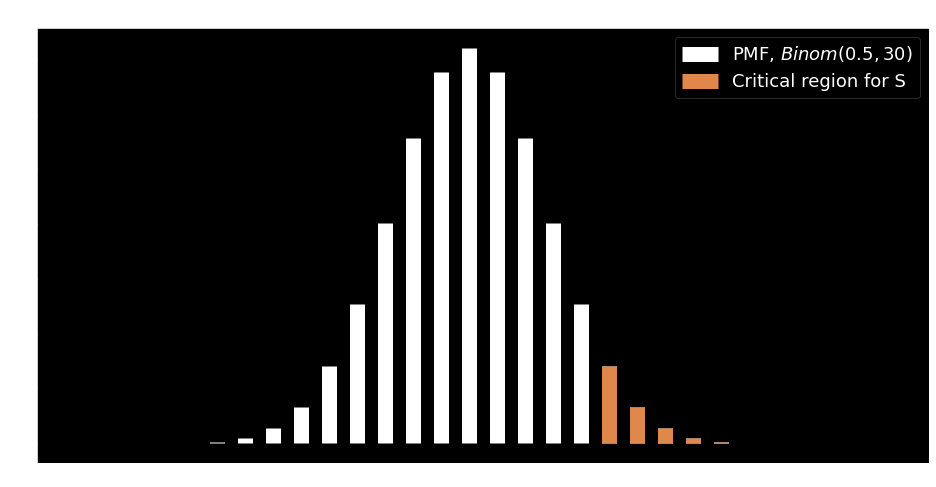

In [13]:
pyplot.figure(figsize=(16, 8))

# строим вертикальные столбцы от 0 до вероятности
pyplot.vlines(x_grid, 0, probs, linewidth=15.0, color='white', label='PMF, $Binom(0.5, 30)$')
# отдельно изобразим критическую области критерия
crit_reg = x_grid >= 20
pyplot.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=15.0, label='Critical region for S')

pyplot.title('Binomial distribution', fontsize=20)
pyplot.legend(fontsize=18)
pyplot.show()

На самом деле уже сейчас мы можем посчитать вероятность попадания в критическую область. Нужно просто просуммировать высоты оранжевых столбцов.

In [14]:
numpy.sum(probs[crit_reg])

0.04936857335269421

Получаем то число, которое было в части 2. Значит мы действительно построили критерий уровня значимости $\alpha = 0.05$. Более того, это критерий уровня значимости $0.0494$, но такую точность обычно не используют.

А что если бы мы взяли $C = 19?$

In [15]:
crit_reg = x_grid >= 19
numpy.sum(probs[crit_reg])

0.10024421103298595

Тогда вероятность ошибки уже даже больше $10\%$, что совсем нам не подходит. Видно, что нет такого $C$, чтобы False Positive Rate был ровно $5\%$.

### Кумулятивная функция распределения

Кумулятивная функция распределения $F_\xi(x) = P(\xi \leqslant x)$

В Python это функция `cdf` (cumulative distribution function)

In [13]:
binom_h0.cdf(19)

0.9506314266473055

По строчке выше понятно, что вероятность получить $19$ или меньше успехов в нашей задаче $\geqslant 0.95$. А поскольку $P(\xi \leqslant 19) + P(\xi \geqslant 20) = 1$, можем вычислить уровень значимости нашего критерия.

In [14]:
1 - binom_h0.cdf(19)

0.04936857335269451

### Квантиль

Чтобы выбрать критическую область для критерия, мы хотели бы найти точку, площадь столбцов справа от которой была бы $5\%$. То есть площадь столбцов слева &mdash; $95\%$. Такая точка называется *квантилью*.

$$ u_p(\xi) = \{x\ | F_\xi(x) = p\} $$

Но при $p = 0.95$ и нашем биномиальном распределении, такой точки нет. Мы выяснили, что есть точка, справа от которой площадь $0.494$, а у следующей уже $0.1$. Чтобы определить квантиль в этом случае, модифицируем определение:

Квантиль $Quantile_p(\xi) = u_p(\xi) = min\ \{x\ |\ F_\xi(x) \geqslant p \}$ &mdash; величина, которую $\xi$ не превышает с вероятностью хотя бы $p$.

**Пример**

Для величины $\xi \sim Bin(30, 0.5)$ посчитаем 0.95-квантиль. Решим задачу просто подбором.

$$ P(\xi \leqslant 18) \approx 0.90$$
$$ P(\xi \leqslant 19) \approx 0.951 $$
$$ P(\xi \leqslant 20) \approx 0.97 $$

Видим, что 18 нам ещё не подходит, а 19 и большие значение уже подойдут. В них функция распределения будет больше $p$. Ответ - наименьшее подходящее значение, то есть 19. При этом нет точки, где функция распределения была бы равна $p$ в точности.


Если бы распределение было непрерывное, можно было бы сказать, что квантиль &mdash; такое $x$, на котором функция распределения равна $p$. Но в прошлом пункте увидели, что для дискретного распределения такого может не быть.

В Python квантиль можно посчитать через функцию `ppf` (percent point function)

In [15]:
binom_h0.ppf(0.95)

19.0

Как теперь подобрать $C$ для любых $n, \mu$ и для любого уровня значимости $\alpha$?

1. Требуется найти $C$, такое что $P(Q \geqslant C) \leqslant \alpha$
2. То есть требуется $P(Q < C) \geqslant 1 - \alpha$
3. Q принимает только целые значения: $P(Q \leqslant C - 1) \geqslant 1 - \alpha$, или $F(C - 1) \geqslant 1 - \alpha$
4. Значит, из определения квантили, $C - 1 = u_{1 - \alpha}$
5. Значит $C = u_{1 - \alpha} + 1$

In [16]:
def make_binom_criterion(n, mu=0.5, alpha=0.05):
    '''Строит критерий для задачи с доставкой
    
    Параметры:
        n: количество доставок в эксперименте
        mu: вероятность успеха в нулевой гипотезе
        alpha: уровень значимости критерия
        
    Возвращает:
        C для критерия S = {Q >= C}
    '''
    binom_h0 = binom(n=n, p=mu)
    q = binom_h0.ppf(1 - alpha)
    return q + 1

Применим к нашей постановке

In [17]:
print(f'if Q >=', make_binom_criterion(
    n=30,
    mu=0.5,
    alpha=0.05
), 'then reject H0')

if Q >= 20.0 then reject H0


Критическое значение $20$, значит итоговый критерий выглядит так

$$ S = \{Q \geqslant 20\} $$


$Q = 19$, значит гипотезу мы не отвергаем.

При этом нам удалось построить процесс, по которому мы принимаем решение для любого уровня значимости и значения статистики критерия.

## Часть 4. p-value

Заметим, что сейчас, если нам зададут другую $\alpha$, нам придётся перестраивать критерий заново. Это не совсем удобно. В статистике есть механизм *p-value*, который позволяет принять решения для всех $\alpha$ сразу.

### Более экстремальные значения

Предположим, мы провели эксперимент и посчитали для критерия его статистику $Q(\xi)$. Обозначим полученное значение $q$, в текущей задаче это $q = 19$. Если бы количество успешных доставок было ещё больше, это бы сильнее свидетельствовало о том, что гипотеза $\mathsf{H}_0$ не выполнена. То есть в случае значения $25$ мы были бы ещё сильнее уверены в том, что наш бизнес будет окупаться. Тогда значение $25$ называется *более экстремальным*, чем значение $19$. В нашей задаче более экстремально из двух значений то, которое больше.

Определим понятие экстремальности формально:

$$ S = \{Q(\xi) \geqslant C\}:\ t\ \text{экстремальнее}\ q \Leftrightarrow t > q $$

Зачастую критерии других видов можно привести к этому, тогда для них тоже определено понятие экстремальности.

### p-value

**p-value** &mdash; это вероятность при справедливости $\mathsf{H}_0$ получить столь же экстремальное значение статистики $q$ или ещё более экстремальное.

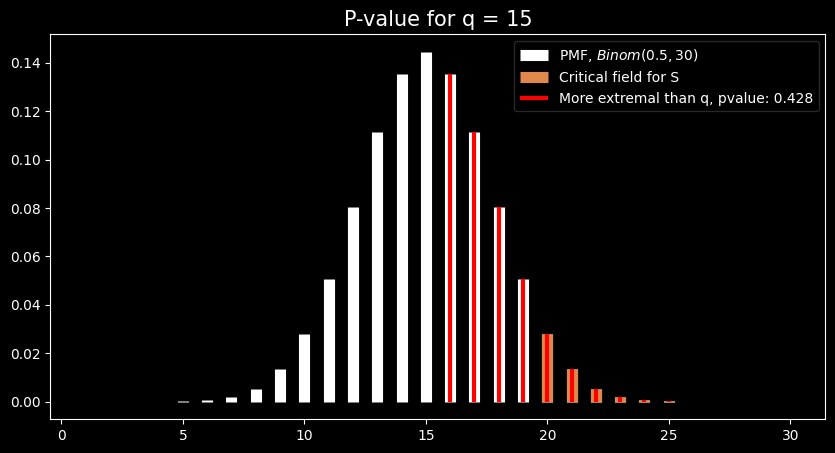

Научимся считать p-value. Будем итеративно по строчкам расписывать формулу, добавляя кусочки определения.

p-value &mdash; это **вероятность**

$$ P( $$

**при справедливости $\mathsf{H}_0$** (в нашем примере, статистика имеет биномиальное распределение с вероятностью успеха 0.5)

$$ P_{\mathsf{H}_0}( $$

получить **такое же** значение **статистики** или **более экстремальное** (в нашем случае значит большее либо равное)

$$ P_{\mathsf{H}_0}(Q \geqslant q) $$

Теперь выведем формулу через функции Python:

$$ pvalue(q) = P_{\mathsf{H}_0}(Q \geqslant q) = 1 - P_{\mathsf{H}_0}(Q < q) =  1 - P_{\mathsf{H}_0}(Q \leqslant q - 1) = 1 - \text{binom_h0.cdf(q - 1)}$$

Изобразим на графике область более экстремальных значений и p-value для разных значений статистики.

In [18]:
C = 20  # критическое значение
qs = [10, 19, 20, 23]  # разные реализации статистики

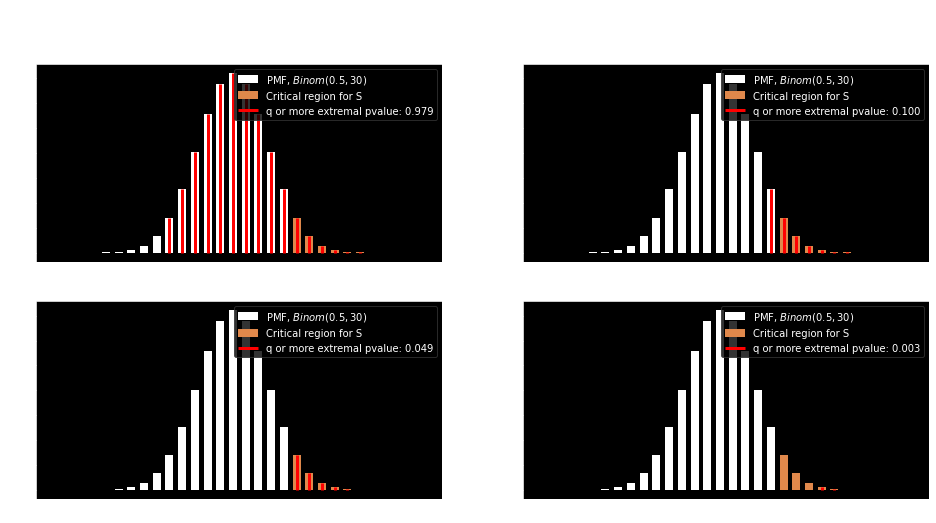

In [19]:
fig, axes = pyplot.subplots(2, 2, figsize=(16, 8))

for q, ax in zip(qs, axes.flatten()):
    ax.set_title(f'$q = {q}$' + (' [our experiment]' if q == 19 else ''))
    # строим вертикальные столбцы от 0 до вероятности
    ax.vlines(x_grid, 0, probs, linewidth=8.0, color='white', label='PMF, $Binom(0.5, 30)$')
    # отдельно изобразим критическую области критерия
    crit_reg = x_grid >= 20
    ax.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=8.0, label='Critical region for S')

    # посчитаем площадь более экстремальных значений
    pvalue = 1 - binom_h0.cdf(q - 1)
    # изобразим такие же и более экстремальные значения на графике
    more_extremal = x_grid >= q
    ax.vlines(
        x_grid[more_extremal], 0, probs[more_extremal], linewidth=3.0, color='red',
        label='q or more extremal pvalue: {:.3f}'.format(pvalue)
    )
    ax.legend()

pyplot.suptitle('P-values for different q', fontsize=20)
pyplot.show()

Можно увидеть, что в критической области $p-value \leqslant \alpha$, а вне её $p-value > \alpha$. Именно такое правило и используется для принятия решения

$$ \mathsf{H}_0 \text{ отвергается } \Leftrightarrow p-value \leqslant \alpha $$

Причём по p-value сразу видно, что если бы в нашу критическую области включили значение $19$, наш критерий допускал бы False Positive в $10\%$ случаев, что уже недопустимо. Поэтому и гипотезу мы не отвергаем.

Заметим, что для вычисления p-value не понадобилось знание $\alpha$, а нужна была только статистика и форма критерия.

## Часть 5. Двусторонные критерии

До этого момента нас интересовали отклонения от вероятности в $50\%$ только в одну сторону. И логично, ведь это продиктовано бизнес-смыслом. Только большая доля успешных доставок приведёт к успеху. И обычно при принятии решений так и бывает. **При тестировании нового решения или продукта рассматривают альтернативную гипотезу только в сторону улучшения**, потому что в противном случае нет смысла внедрять решение на всех пользователей.


Однако **иногда** может потребоваться доказывать отклонения в обе стороны, если вы проверяете какое-то предположение. Пусть вам дали монетку и просят проверить, честная она или нет. Монетка честная, если при подбрасываниях вероятность выпадения орла равна $0.5$. Вы подбрасываете монетку $30$ раз, каждый бросок &mdash; бернуллиевская величина, аналогично задаче с доставками. И нулевая гипотеза та же самая: $\mu = 0.5$. Но теперь мы хотим отвергать эту  гипотезу как в случае большой вероятности орла, так и в случае маленькой, соответственно проверяем *двустороннюю гипотезу*.

$$ \mathsf{H}_0: \mu = 0.5 $$
$$ \mathsf{H}_1: \mu \neq 0.5 $$

Выберем критическую область для критерия при такой альтернативе. Воспользуемся той же статистикой $Q(\xi) = \sum \xi_i$. Только теперь отклонения в каждую сторону одинаково важны. Отвергать гипотезу будем не только на достаточно больших значениях, но и на достаточно маленьких. Например, если у нас было всего $2$ орла из $30$ &mdash; это свидетельство в пользу того, что $\mu \neq 0.5$, но не в пользу $\mu > 0.5$.

Поскольку отклонения в разные стороны одинаково важны, а распределение симметричное, искать критерий можно в таком виде:

$$ S = \{|Q(\xi) - 15| \geqslant C\} $$

### Как выбрать критическую область

Посмотрим, как будет выглядеть критическая область в таком случае.

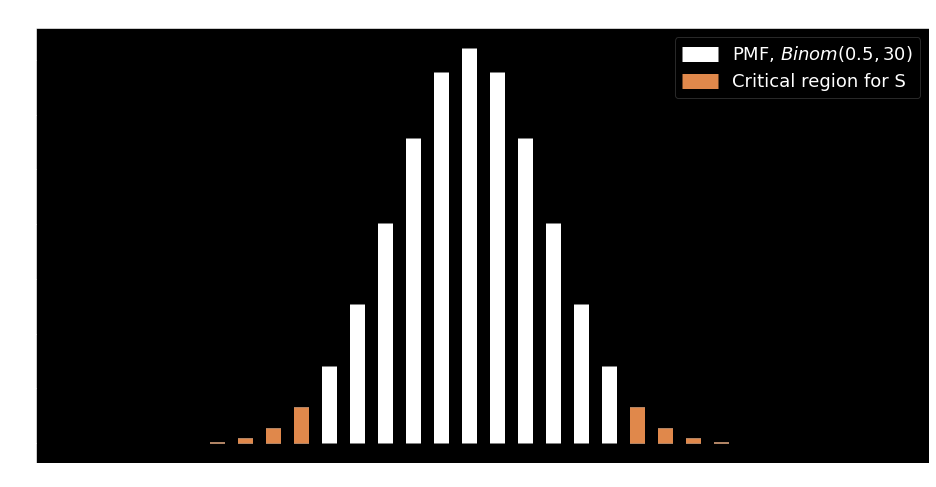

In [20]:
C = 6

pyplot.figure(figsize=(16, 8))

# строим вертикальные столбцы от 0 до вероятности
pyplot.vlines(x_grid, 0, probs, linewidth=15.0, color='white', label='PMF, $Binom(0.5, 30)$')
# отдельно изобразим критическую области критерия
crit_reg = numpy.abs(x_grid - 15) >= C
pyplot.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=15.0, label='Critical region for S')

rejection_prob = probs[crit_reg].sum()
pyplot.title('Two-sided criteria, C = {}, critical region proba = {:.3f}'.format(C, rejection_prob), fontsize=20)
pyplot.legend(fontsize=18)
pyplot.show()

По картинке видно, что если теперь отвергать отклонения при $Q \geqslant 20$, то необходимо отвергать и $Q \leqslant 10$, а значит общая площадь столбцов будет уже примерно $0.1$. Поэтому при уровне значимости $0.05$ и $20$ успехах гипотеза уже не отвергнется.

Если же выставить $C = 6$, то такая область уже подходит, площадь столбцов $\approx 0.043 < 0.05$

Чтобы выбрать пороговую константу по формуле, можно заметить, что критическая область симметрична, а значит справа площадь не должна быть больше, чем $\frac{\alpha}{2}$. А такую задачу мы уже умеем решать. Реализуем функцию на Python.

In [24]:
def make_binom_criterion_two_sided(n, alpha=0.05):
    '''Строит критерий для задачи с доставкой для mu = 0.5 и двусторонней альтернативы
    
    Параметры:
        n: количество доставок в эксперименте
        mu: вероятность успеха в нулевой гипотезе
        alpha: уровень значимости критерия
        
    Возвращает:
        C для критерия S = {|Q - 15| >= C}
    '''
    # определяем границу справа для alpha / 2
    right_crit_val = make_binom_criterion(n, mu=0.5, alpha = alpha / 2)
    # считаем отклонение, начиная с которого отвергать
    diff = right_crit_val - 15
    return diff

In [25]:
make_binom_criterion_two_sided(30)

6.0

Получили то же, что и по картинке.

### Как считать p-value

Критерий имеет вид

$$ S = \{|Q(\xi) - 15| \geqslant C\} $$

Обозначим отклонение суммы от 15 как $ \Delta(\xi) =  |Q(\xi) - 15| $, тогда мы имеем критерий

$$ S = \{\Delta(\xi) \geqslant C\} $$

То есть более экстремальными будут считаться те значения суммы, которые находятся дальше от 15. Чтобы вычислить p-value, придётся посчитать сумму площадей с двух сторон по-отдельности.

In [26]:
def pvalue_two_sided_sym(n, q):
    '''Считает pvalue для задачи с доставкой для mu = 0.5 и двусторонней альтернативы
    
    Параметры:
        n: количество доставок в эксперименте
        q: количество успешных доставок
        
    Возвращает:
        pvalue для критерия S = {|Q - 15| >= C}
    '''
    binom_h0 = binom(n=n, p=0.5)
    diff = numpy.abs(q - 15)
    # смотрим более экстремальные отклонения с правой стороны
    right_sq = 1 - binom_h0.cdf(15 + diff - 1)
    # смотрим более экстремальные отклонения с левой стороны
    left_sq = binom_h0.cdf(15 - diff)
    return left_sq + right_sq

На самом деле в силу симметричности распределения левая и правая площадь получаются одинаковыми, поэтому можно посчитать площадь с одной стороны и умножить на 2.

In [27]:
def pvalue_two_sided_sym_simple(n, q):
    '''Считает pvalue для задачи с доставкой для mu = 0.5 и двусторонней альтернативы
    
    Параметры:
        n: количество доставок в эксперименте
        q: количество успешных доставок
        
    Возвращает:
        pvalue для критерия S = {|Q - 15| >= C}
    '''
    binom_h0 = binom(n=n, p=0.5)
    diff = numpy.abs(q - 15)
    # смотрим более экстремальные отклонения с правой стороны
    right_sq = 1 - binom_h0.cdf(15 + diff - 1)
    return 2 * right_sq

In [28]:
pvalue_two_sided_sym(n=30, q=21)

0.04277394525706768

In [29]:
pvalue_two_sided_sym_simple(n=30, q=21)

0.04277394525706768

Теперь даже в случае $20$ орлов $pvalue > 0.05$, поэтому отвергать будем значения, начиная с $21$ и меньше либо равные $9$.

### Случай с несимметричным распределением

Когда распределение при справедливости $\mathsf{H}_0$ несимметрично, отклонения от ожидаемого значения в разные стороны могут быть по-разному критичны. В качестве примера рассмотрим также биномиальное распределение, но с вероятностью успеха $0.8$. 

Тогда можно левую и правую критические области построить отдельно, выделив на них по $\frac{\alpha}{2}$ площади. Правую область мы уже умеем искать, найдём левую.

In [16]:
binom_h0_nonsym = binom(
    n=30, # количество испытаний
    p=0.8 # вероятность успеха
)

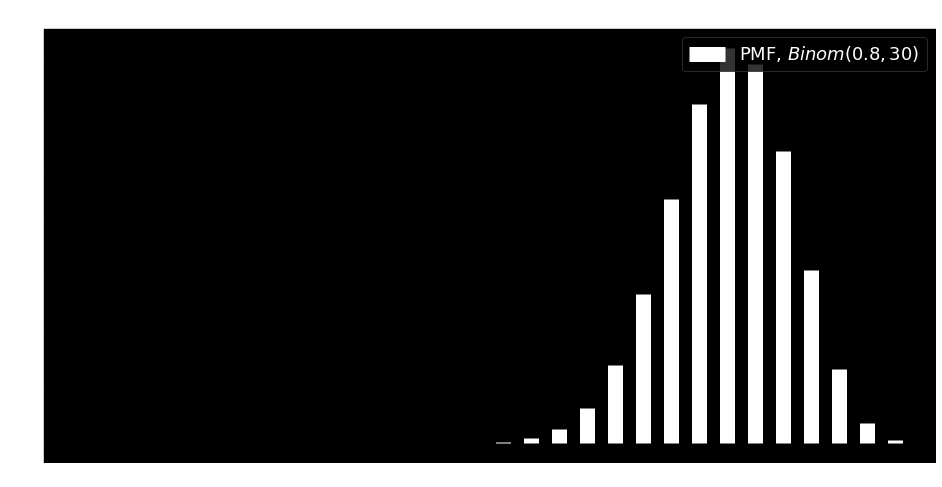

In [17]:
pyplot.figure(figsize=(16, 8))

# считаем вероятности значений суммы
probs = binom_h0_nonsym.pmf(x_grid)
# строим вертикальные столбцы от 0 до вероятности
pyplot.vlines(x_grid, 0, probs, linewidth=15.0, color='white', label='PMF, $Binom(0.8, 30)$')

pyplot.title('Binomial distribution', fontsize=20)
pyplot.legend(fontsize=18)
pyplot.show()

Для того, чтобы построить двусторонний критерий, нужно найти слева и справа области, площадь которых составляет не больше, чем $\frac{\alpha}{2}$. Для правой стороны мы уже решали такую задачу, решим для левой.

Ищем $C$, такое что

$$ P(Q(\xi) \leqslant C) \leqslant \frac{\alpha}{2} $$

Сначала найдём первое число, где вероятность $\geqslant \frac{\alpha}{2}$. А это по определению $\frac{\alpha}{2}$-квантиль. Достаточно взять предыдущее число, и оно будет удовлетворять нашему условию.

In [32]:
def two_sided_criterion_nonsym(n, mu, alpha):
    '''Строит двусторонний критерий для несимметричной задачи с доставкой
    
    Параметры:
        n: количество доставок в эксперименте
        mu: вероятность успеха в нулевой гипотезе
        alpha: уровень значимости критерия
        
    Возвращает:
        C1, C2 для критерия S = {Q <= C1 или Q >= C2}
    '''
    binom_h0 = binom(n=n, p=mu)
    
    # аналогично одностороннему критерию
    c2 = binom_h0.ppf(1 - alpha/2) + 1
        
    # по выкладкам выше
    c1 = binom_h0.ppf(alpha/2) - 1
    
    return c1, c2

In [33]:
c1, c2 = two_sided_criterion_nonsym(30, 0.8, 0.05)

In [34]:
c1, c2

(18.0, 29.0)

Значит наш критерий для проверки гипотезы

$$ \mathsf{H}_0: \mu = 0.8 $$
$$ \mathsf{H}_1: \mu \neq 0.8 $$

имеет вид

$$ S = \{Q(\xi) \leqslant 18\} \cup \{Q(\xi) \geqslant 29\}$$

Здесь граница $29$ уже выглядит логично, потому что надо опровергнуть 80% орлов/успехов, а для этого требуется большое их количество.

Изобразим критическую область на графике.

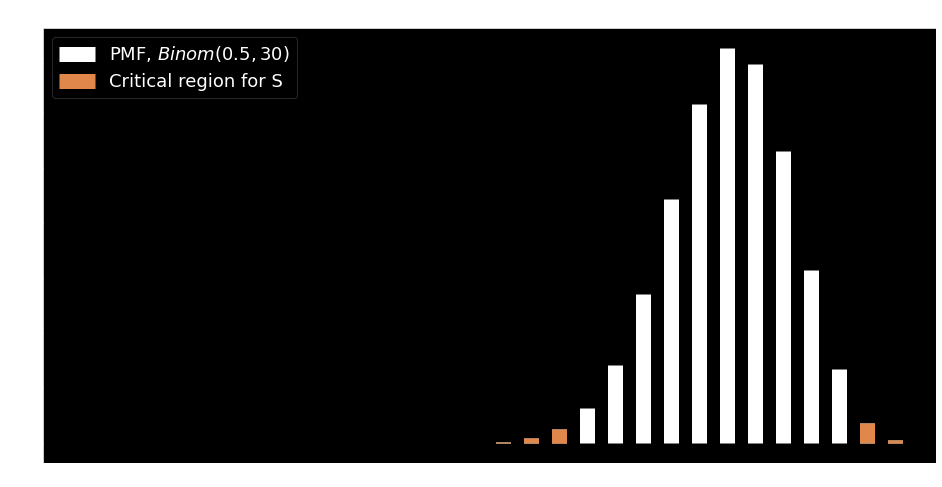

In [35]:
pyplot.figure(figsize=(16, 8))

# считаем вероятности значений суммы
probs = binom_h0_nonsym.pmf(x_grid)
# строим вертикальные столбцы от 0 до вероятности
pyplot.vlines(x_grid, 0, probs, linewidth=15.0, color='white', label='PMF, $Binom(0.5, 30)$')
# отдельно изобразим критическую области критерия
crit_reg = (x_grid >= 29) | (x_grid <= 18)
pyplot.vlines(x_grid[crit_reg], 0, probs[crit_reg], linewidth=15.0, label='Critical region for S')

pyplot.title('Binomial distribution', fontsize=20)
pyplot.legend(fontsize=18, loc='upper left')
pyplot.show()

### p-value для несимметричного распределения

Этот критерий &mdash; объединение двух критериев уровня значимости $\frac{\alpha}{2}$, для каждого из которых можно посчитать p-value. Обозначим их как $p_1, p_2$. Первый критерий отвергается при $p_1 \leqslant \frac{\alpha}{2}$, второй при $p_2 \leqslant \frac{\alpha}{2}$. А наш объединённый, когда выполнено одно из этих условий, то есть

$$ 2p_1 \leqslant \alpha \vee 2p_2 \leqslant \alpha \Leftrightarrow 2 \cdot \min(p_1, p_2) \leqslant \alpha $$

Значит можно считать pvalue как $2  \min(p_1, p_2)$ и сравнивать с $\alpha$.

Проведём аналогию с симметричным случаем: если сумма оказалась в левой части, то нужно посчитать p-value левого критерия и умножить на 2. Если сумма оказалась в правой части, то нужно посчитать p-value правого критерия и умножить на 2.

In [36]:
def pvalue_two_sided(n, q, mu=0.5):
    '''Считает pvalue для двусторонней альтернативы в задаче с доставкой
    
    Параметры:
        n: количество доставок в эксперименте
        q: количество успешных доставок
        mu: вероятность успеха при H0
        
    Возвращает:
        pvalue для двустороннего критерия
    '''
    binom_h0 = binom(n=n, p=mu)
    # считаем для левой части
    pvalue_left = binom_h0.cdf(q)
    # считаем для правой части
    pvalue_right = 1 - binom_h0.cdf(q - 1)
    # вычисляем формулу
    return 2 * min(pvalue_left, pvalue_right)

Посчитаем p-value для $q = 28$

In [37]:
pvalue_two_sided(n=30, q=28, mu=0.8)

0.08835797030399428

Видно, что $p-value > 0.05$, значит на уровне значимости $0.05$ даже $28$ успехов недостаточно, чтобы отвергнуть вероятность успеха в $80\%$.

Заметим, что эта же функция работает и для симметричного случая, возвращая тот же результат

In [38]:
pvalue_two_sided(n=30, q=20, mu=0.5)

0.09873714670538902

In [39]:
pvalue_two_sided_sym(n=30, q=20)

0.09873714670538905

### Итог

Мы построили функции, которые для выборки из распределения Бернулли позволяют проверить гипотезу $\mathsf{H}_0: \mu = M$ для случая правосторонней и двухсторонней альтернатив на любом уровне значимости и размере выборки.